ML Classification on asset prices

In [1]:
# Importing necessary library
import pandas as pd
import numpy as np
from datetime import datetime
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

# Set the seaborn visualization style
sns.set()

In [2]:
df = pdr.DataReader('BTC-USD','yahoo', start="2014-12-31", end="2019-12-31")

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-31,320.192993,310.210999,310.914001,320.192993,13942900,320.192993
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007


In [4]:
# Make the copy of the data. We will work on the copied data.
data = df.copy()

### Inspect the Data

In [6]:
# Inspect the data
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-31,320.192993,310.210999,310.914001,320.192993,13942900,320.192993
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007


In [7]:
# Check the shape of the data
data.shape

(1828, 6)

### Generating Returns and Target Values

In [8]:
# Generate log returns
data['returns'] = np.log(data['Close'] / data['Close'].shift(1))

If the next day is up day, we will designate it with 1, else if it is a down day, we will mark it with -1.

In [9]:
# Create target values
data['target'] = np.where(data.returns.shift(-1) > 0, 1, -1)
data.head()

,High,Low,Open,Close,Volume,Adj Close,returns,target
Date,,,,,,,,
2014-12-31,320.192993,310.210999,310.914001,320.192993,13942900,320.192993,NaN,-1
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993,-0.018738,1
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013,0.002489,-1
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001,-0.114028,-1
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007,-0.061959,1


In [10]:
# Count the values in the target column
data['target'].value_counts()

 1    1002
-1     826
Name: target, dtype: int64

In [11]:
features = ['Volume','returns']
label = 'target'


### Feature Selection

We have OHLCV data with us. These OHCLV columns are our features. Based on this data, we will try to predict the next day's movement. But let's first understand which of these features can actually be used. Our intuition says that Close price plays the major role in the determining the next days movement. So we'll be considering it. What about other features.

To decide on what features to use and which one to ignore, let's analyze their relationship, starting with the Volume column.

In [12]:
data['target'].value_counts()

 1    1002
-1     826
Name: target, dtype: int64

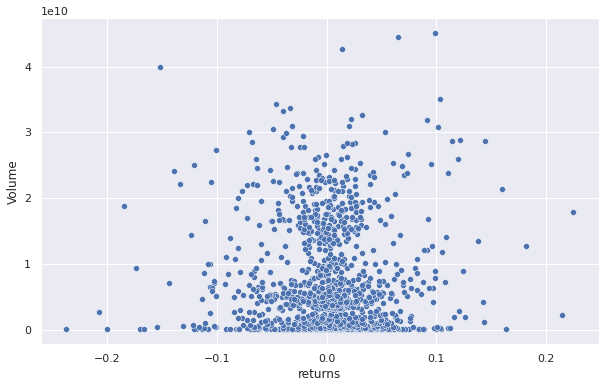

In [13]:
# Scatter plot of Close and Volume
plt.figure(figsize=(10,6))
sns.scatterplot(x=data['returns'], y=data['Volume']);

### Feature Extraction

Let's try to create new features. We will consider the following quantitative features.

- Rolling standard deviation
- Rolling moving average of close price
- Rolling percentage change
- Rolling moving average of volume
- Difference between close and open

In [14]:
# Creating features
features_list = []

# SD based features
for i in range(5, 20, 5):
    col_name = 'std_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).std()
    features_list.append(col_name)
    
# MA based features
for i in range(10, 30, 5):
    col_name = 'ma_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).mean()
    features_list.append(col_name)
    
# Daily pct change based features
for i in range(3, 12, 3):
    col_name = 'pct_' + str(i)
    data[col_name] = data['Close'].pct_change().rolling(i).sum()
    features_list.append(col_name)
    
# Feature based on volume
col_name = 'vma_4'
data[col_name] = data['Volume'].rolling(4).mean()
features_list.append(col_name)

# Intraday movement
col_name = 'co'
data[col_name] = data['Close'] - data['Open']
features_list.append(col_name)

In [15]:
features_list

['std_5',
 'std_10',
 'std_15',
 'ma_10',
 'ma_15',
 'ma_20',
 'ma_25',
 'pct_3',
 'pct_6',
 'pct_9',
 'vma_4',
 'co']

In [16]:
# Removing nan values
data.dropna(inplace=True)

In [17]:
data[features_list+['target']].head()

,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co,target
Date,,,,,,,,,,,,,
2015-01-24,13.191510,15.040683,27.304701,219.474500,227.130731,241.785898,253.218759,0.090703,0.169436,0.174246,28218350.0,15.147003,1
2015-01-25,11.292898,18.022755,25.132423,223.861900,225.725532,240.748098,250.559759,0.085704,0.171625,0.206259,29132875.0,6.365997,1
2015-01-26,16.754638,22.873331,26.082191,230.399500,226.246398,240.112298,248.928719,0.165824,0.265991,0.326587,47445225.0,19.393997,-1
2015-01-27,15.432282,22.162699,25.610106,236.821001,225.958332,238.569198,246.866439,0.064991,0.155694,0.234427,52389550.0,-9.691986,-1
2015-01-28,15.075979,20.199651,25.692217,239.178600,226.495266,236.097498,244.979758,-0.070890,0.014814,0.100735,57281975.0,-29.436020,-1


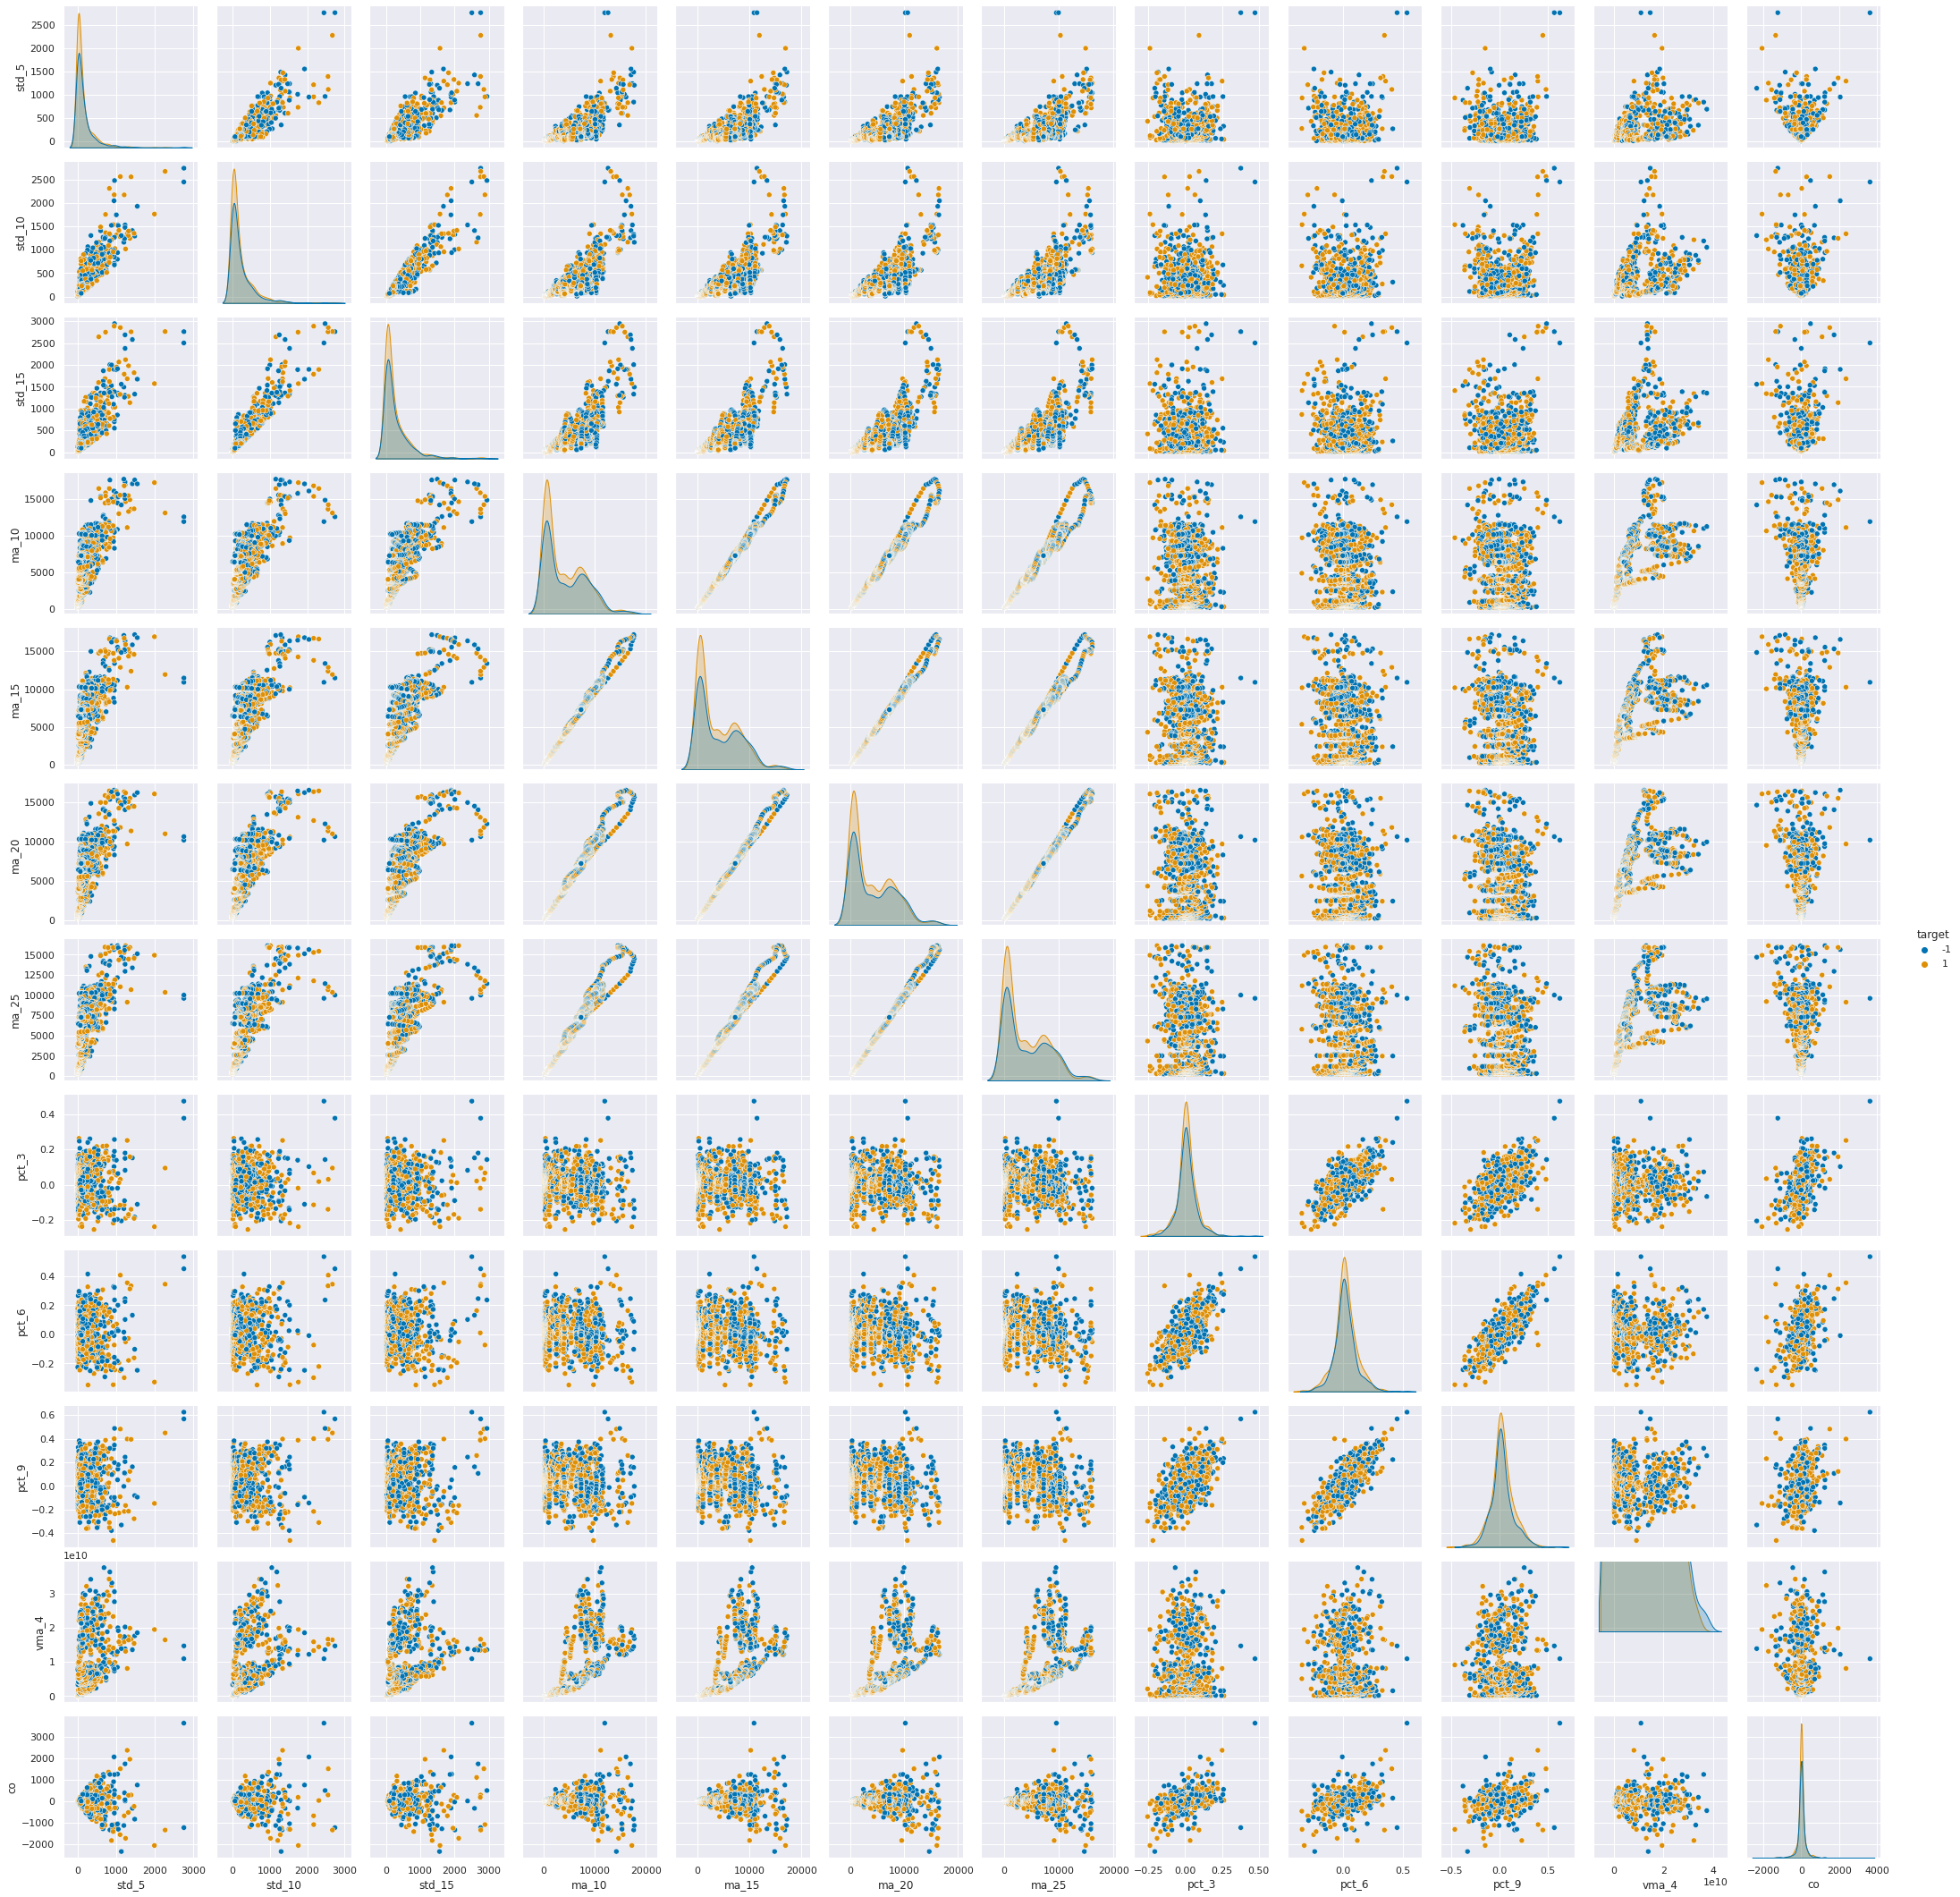

In [18]:
#first show
#sns.pairplot(data[features_list+['target']],hue='target')

#do next b/c easier viewing - takesawhile
sns.pairplot(data[features_list+['target']],hue='target',palette='colorblind')

### Generating Training and Testing Datasets

In [19]:
X_train , X_test,Y_train,Y_test = train_test_split(data[features_list].iloc[:-1],
                                                   data.iloc[:-1]['target'],
                                                   test_size= 0.2)
X_train.shape, Y_train.shape,X_test.shape, Y_test.shape

((1442, 12), (1442,), (361, 12), (361,))

### Feature Scaling

In [20]:
X_train.columns

Index(['std_5', 'std_10', 'std_15', 'ma_10', 'ma_15', 'ma_20', 'ma_25',
       'pct_3', 'pct_6', 'pct_9', 'vma_4', 'co'],
      dtype='object')

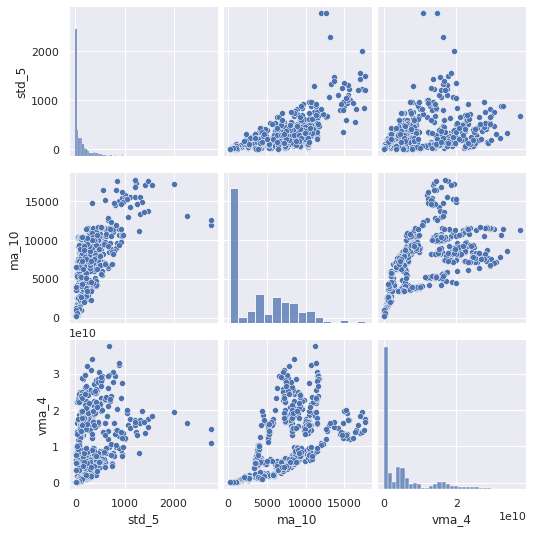

In [21]:
sns.pairplot(X_train[['std_5','ma_10','vma_4']])

In [22]:
# Scaling the features
#scaler = StandardScaler()
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

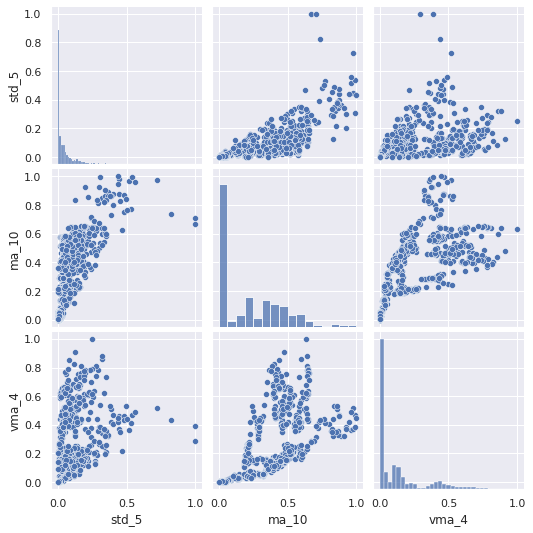

In [23]:
X_train_scaled_df = pd.DataFrame(X_train_scaled,columns=X_train.columns)
sns.pairplot(X_train_scaled_df[['std_5','ma_10','vma_4']])

In [24]:
X_train_scaled_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
std_5,1442.0,0.05,0.09,0.0,0.00,0.02,0.06,1.0
std_10,1442.0,0.08,0.12,0.0,0.00,0.02,0.10,1.0
std_15,1442.0,0.09,0.14,0.0,0.00,0.03,0.13,1.0
ma_10,1442.0,0.21,0.23,0.0,0.01,0.14,0.39,1.0
ma_15,1442.0,0.22,0.23,0.0,0.01,0.14,0.40,1.0
ma_20,1442.0,0.23,0.24,0.0,0.01,0.14,0.42,1.0
ma_25,1442.0,0.23,0.25,0.0,0.01,0.15,0.42,1.0
pct_3,1442.0,0.36,0.09,0.0,0.32,0.36,0.40,1.0
pct_6,1442.0,0.41,0.11,0.0,0.36,0.41,0.46,1.0
pct_9,1442.0,0.45,0.11,0.0,0.40,0.44,0.50,1.0


In [25]:
# Create model
model = LogisticRegression()

# Train model
model.fit(X_train_scaled, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
# Predict on train dataset
Y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
Y_pred = model.predict(X_test_scaled)

Model accuracy on training data: 0.565880721220527
Model accuracy on testing data: 0.5484764542936288


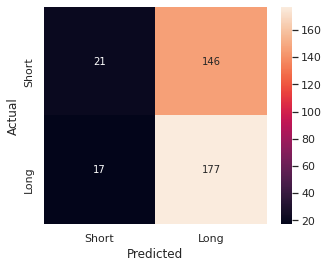

              precision    recall  f1-score   support

          -1       0.55      0.13      0.20       167
           1       0.55      0.91      0.68       194

    accuracy                           0.55       361
   macro avg       0.55      0.52      0.44       361
weighted avg       0.55      0.55      0.46       361



In [27]:
#sklearn way - say they could have also done model.score
print('Model accuracy on training data:', accuracy_score(Y_train, Y_pred_train))
print('Model accuracy on testing data:', accuracy_score(Y_test, Y_pred))

# Plotting Confustion matrix
cm = confusion_matrix(Y_test, Y_pred)
df = pd.DataFrame(cm, index=['Short', 'Long'], columns=['Short', 'Long'])
plt.figure(figsize=(5, 4))
sns.heatmap(df, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Printing classification report
print(classification_report(Y_test, Y_pred))

## For TSLA

Granted, I should have cleaned the code up a bit and modularized everything, but I just wanted to view the analysis.

Model accuracy on training data: 0.524822695035461
Model accuracy on testing data: 0.5182186234817814


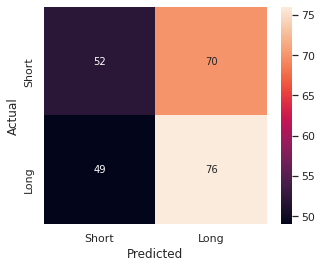

              precision    recall  f1-score   support

          -1       0.51      0.43      0.47       122
           1       0.52      0.61      0.56       125

    accuracy                           0.52       247
   macro avg       0.52      0.52      0.51       247
weighted avg       0.52      0.52      0.51       247



In [29]:
data = pdr.DataReader('TSLA','yahoo', start="2014-12-31", end="2019-12-31")

data['returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['target'] = np.where(data.returns.shift(-1) > 0, 1, -1)

# Creating features
features_list = []

# SD based features
for i in range(5, 20, 5):
    col_name = 'std_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).std()
    features_list.append(col_name)
    
# MA based features
for i in range(10, 30, 5):
    col_name = 'ma_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).mean()
    features_list.append(col_name)
    
# Daily pct change based features
for i in range(3, 12, 3):
    col_name = 'pct_' + str(i)
    data[col_name] = data['Close'].pct_change().rolling(i).sum()
    features_list.append(col_name)
    
# Feature based on volume
col_name = 'vma_4'
data[col_name] = data['Volume'].rolling(4).mean()
features_list.append(col_name)

# Intraday movement
col_name = 'co'
data[col_name] = data['Close'] - data['Open']
features_list.append(col_name)

data.dropna(inplace=True)

X_train , X_test,Y_train,Y_test = train_test_split(data[features_list].iloc[:-1],
                                                   data.iloc[:-1]['target'],
                                                   test_size= 0.2)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create model
model = LogisticRegression()

# Train model
model.fit(X_train_scaled, Y_train)

# Predict on train dataset
Y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
Y_pred = model.predict(X_test_scaled)

#sklearn way - say they could have also done model.score
print('Model accuracy on training data:', accuracy_score(Y_train, Y_pred_train))
print('Model accuracy on testing data:', accuracy_score(Y_test, Y_pred))

# Plotting Confustion matrix
cm = confusion_matrix(Y_test, Y_pred)
df = pd.DataFrame(cm, index=['Short', 'Long'], columns=['Short', 'Long'])
plt.figure(figsize=(5, 4))
sns.heatmap(df, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Printing classification report
print(classification_report(Y_test, Y_pred))